<a name="2.1"></a>
## 2.1 - Initial data Collection

In [1]:
#Load our local fonctions
from utils_ns import *
# load librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv("data_st/data_prep.csv")

# Résolution

Étape 1: Définition des variables

    X : Nombre de No-show (variable aléatoire représentant la demande aléatoire de No-show).
    Y : Niveau optimal d'overbooking (nombre de rendez-vous supplémentaires à accepter pour maximiser le bénéfice attendu ou minimiser les coûts).
    C : Capacité totale des médecins en temps de service (en unités de temps).

Étape 2: Initialisation des paramètres

    λ (lambda) : Coût de l'overbooking (par exemple, coût d'un patient en plus qui se présente en raison de l'overbooking).
    ρ (rho) : Coût de l'opportunité perdue (par exemple, coût associé à un créneau inutilisé dû à un no-show).

In [3]:
def extract_no_show_history(data, sta3n, year):
    """
    Extrait l'historique du nombre de No-show pour chaque jour d'une année donnée et pour un sta3n spécifique.

    Parameters:
    - data: dataFrame contenant les informations sur les rendez-vous.
    - sta3n: int, identifiant du site `sta3n`.
    - year: int, année pour laquelle extraire les données.

    Returns:
    - dataFrame avec les colonnes 'date' et 'no_show_count', contenant le nombre de No-show par jour.
    """
    # Convertir `activitydatetime` en datetime si ce n'est pas déjà fait
    data['activitydatetime'] = pd.to_datetime(data['activitydatetime'])
    # Filtrer les données pour le `sta3n` spécifique et l'année donnée
    data_filtered = data[(data['sta3n'] == sta3n) & (data['activitydatetime'].dt.year == year)]

    # Convertir `activitydatetime` en date uniquement
    data_filtered['date'] = data_filtered['activitydatetime'].dt.date

    # Compter le nombre de No-show par jour
    no_show_history = data_filtered[data_filtered['NoShow'] == 1].groupby('date').size().reset_index(name='no_show_count')

    return no_show_history

In [4]:
no_show_history = extract_no_show_history(df, sta3n=589, year=2023)

# Tracer l'histogramme de la distribution des No-show
plot_no_show_histogram(no_show_history)

NameError: name 'plot_no_show_histogram' is not defined

## Test 

In [ ]:
# Calcul de la moyenne et de l'écart-type
m = no_show_history['no_show_count'].mean()
s = no_show_history['no_show_count'].std()

In [ ]:
def calculate_critical_fractile(lambda_cost, rho_cost):
    """
    Calcule la critical fractile F(Y) = lambda / (lambda + rho)

    Parameters:
    - lambda_cost: float, le coût de l'overbooking (lambda).
    - rho_cost: float, le coût de l'opportunité perdue (rho).

    Returns:
    - F(Y): float, la critical fractile.
    """
    return lambda_cost / (lambda_cost + rho_cost)


In [5]:
from scipy.stats import norm

def calculate_optimal_overbooking_level(F_Y, mean, std_dev):
    """
    Calcule et arrondit le niveau optimal d'overbooking Y en utilisant la fonction de distribution inverse normale.

    Parameters:
    - F_Y: float, la critical fractile calculée précédemment.
    - mean: float, la moyenne de la distribution des No-show (m).
    - std_dev: float, l'écart-type de la distribution des No-show (s).

    Returns:
    - Y_star_rounded: int, le niveau optimal d'overbooking arrondi.
    """
    Y_star = norm.ppf(F_Y, loc=mean, scale=std_dev)
    return round(Y_star)

In [469]:
# Initialisation des paramètres
lambda_= 0.2 
rho = 0.1 

# Calcul de F(Y)
F_Y = calculate_critical_fractile(lambda_, rho)

# Calcul du niveau optimal d'overbooking Y*
Y_star = calculate_optimal_overbooking_level(F_Y, m, s)

print(f"Niveau optimal d'overbooking Y*: {Y_star}")


Niveau optimal d'overbooking Y*: 11


## Généric distribution

In [481]:
# Fonction pour calculer la critical fractile
def calculate_critical_fractile(lambda_cost, rho_cost):
    return lambda_cost / (lambda_cost + rho_cost)

# Fonction pour calculer le niveau optimal d'overbooking en utilisant la méthode générique
def generic_calculate_optimal_overbooking_level(F_Y, no_show_history):
    sorted_no_shows = no_show_history.sort_values(by='no_show_count')
    sorted_no_shows['cumulative_probability'] = sorted_no_shows['no_show_count'].cumsum() / sorted_no_shows['no_show_count'].sum()
    Y_star = sorted_no_shows.iloc[(sorted_no_shows['cumulative_probability'] - F_Y).abs().argsort()[:1]]['no_show_count'].values[0]
    return Y_star



def process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n=657, num_days=10):
    data = data.sort_values(by='activitydatetime')
    data = data[data['sta3n'] == sta3n]
    last_n_days = data['activitydatetime'].dt.date.unique()[-num_days:]
    data_last_n_days = data[data['activitydatetime'].dt.date.isin(last_n_days)]
    data_last_n_days = data_last_n_days.sort_values(by='activitydatetime', ascending=False)
    
    no_show_vs_overbooking = []

    for day in last_n_days:
        day_data = data_last_n_days[data_last_n_days['activitydatetime'].dt.date == day]
        X = day_data['NoShow'].sum()
        F_Y = calculate_critical_fractile(lambda_cost, rho_cost)
        Y_star = generic_calculate_optimal_overbooking_level(F_Y, no_show_history)
        dispersion = abs(X - Y_star)
        no_show_vs_overbooking.append({'date': day, 'X': X, 'Y_star': Y_star, 'dispersion': dispersion})

    no_show_vs_overbooking_data = pd.DataFrame(no_show_vs_overbooking)
    return no_show_vs_overbooking_data

# Fonction pour réaliser l'analyse de sensibilité et tracer les graphes
def sensitivity_analysis(data, no_show_history, sta3n=657, num_days=10, lambda_values=[50, 100], rho_values=[50, 100]):
    colors = ['red', 'blue', 'green', 'purple']
    markers = ['o', 's', '^', 'D']
    
    plt.figure(figsize=(12, 6))
    
    results_data, no_show_vs_overbooking_data = process_last_n_days(data, 2, 1, no_show_history, sta3n, num_days)
        
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['X'], linestyle=':', color='black', marker=markers[1], label=f'No-show (X)')
    for i, (lambda_cost, rho_cost) in enumerate(zip(lambda_values, rho_values)):
        results_data, no_show_vs_overbooking_data = process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n, num_days)
        
        plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['Y_star'], linestyle='-', color=colors[i], marker=markers[i], label=f'Optimal Overbooking (Y*) λ={lambda_cost}, ρ={rho_cost}')
    
    plt.xlabel('Date')
    plt.ylabel('Noshow count/optimal overbooking limit')
    plt.title('Sensitivity Analysis: Optimal Overbooking limit (Y*)')
    plt.legend()
    plt.grid(True)
    plt.show()

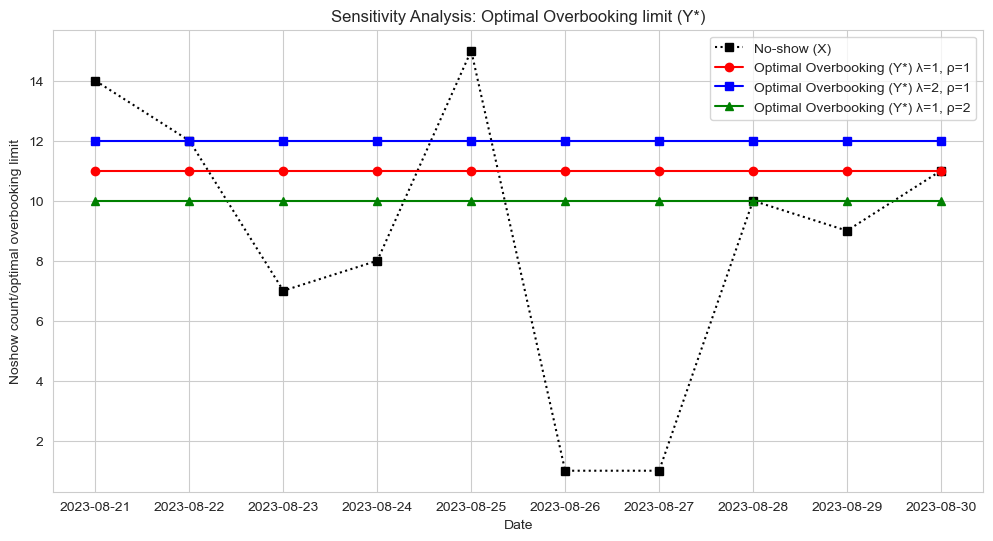

In [482]:
lambda_values = [1, 2, 1]
rho_values = [1, 1, 2]
sensitivity_analysis(df, no_show_history, sta3n=589, num_days=10, lambda_values=lambda_values, rho_values=rho_values)

In [483]:


def plot_dispersion_boxplots(data, no_show_history, sta3n=657, num_days=10, lambda_values=[50, 100], rho_values=[50, 100]):
    plt.figure(figsize=(12, 6))
    
    boxplot_data = []
    labels = []
    colors = ['red', 'blue', 'green', 'purple']
    
    for i, (lambda_cost, rho_cost) in enumerate(zip(lambda_values, rho_values)):
        no_show_vs_overbooking_data = process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n, num_days)
        boxplot_data.append(no_show_vs_overbooking_data['dispersion'].values)  
        labels.append(f'λ={lambda_cost}, ρ={rho_cost}')
    
    # Customizing the boxplot colors
    boxprops = dict(facecolor='white', color='black')
    whiskerprops = dict(color='black')
    capprops = dict(color='black')
    flierprops = dict(markeredgecolor='black')
    medianprops = dict(color='black')
    
    bplot = plt.boxplot(boxplot_data, patch_artist=True, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops)
    
    # Apply colors to the boxes
    for patch, color in zip(bplot['boxes'], colors[:len(boxplot_data)]):
        patch.set_facecolor(color)
    
    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=45)
    plt.title('Dispersion |X−Y*| for Different λ and ρ vvalues')
    plt.ylabel('Dispersion |X−Y*|')
    plt.grid(True)
    plt.show()


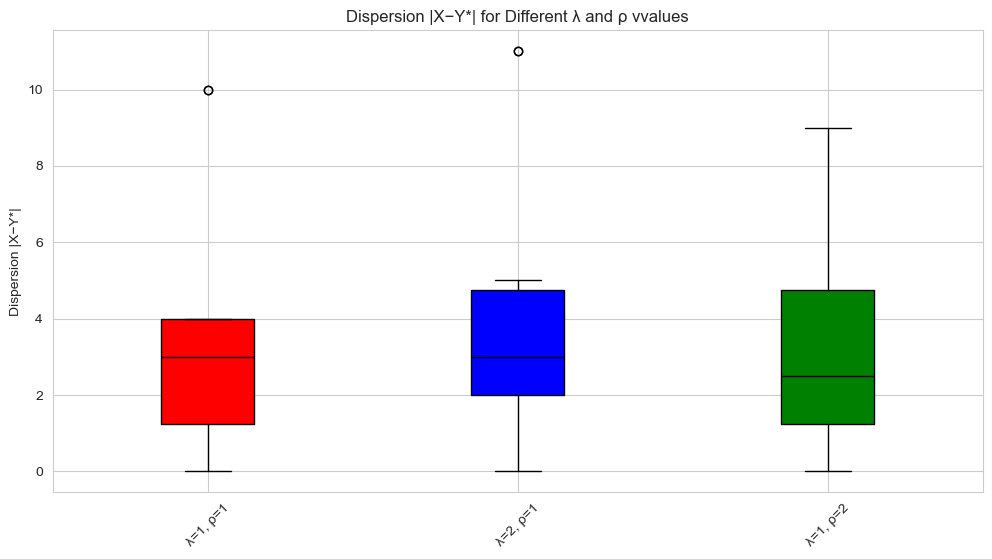

In [477]:
plot_dispersion_boxplots(df, no_show_history, sta3n=589, num_days=10, lambda_values=lambda_values, rho_values=rho_values)

In [478]:
sta3n = 589

In [487]:
lambda_cost = 1
rho_cost = 1

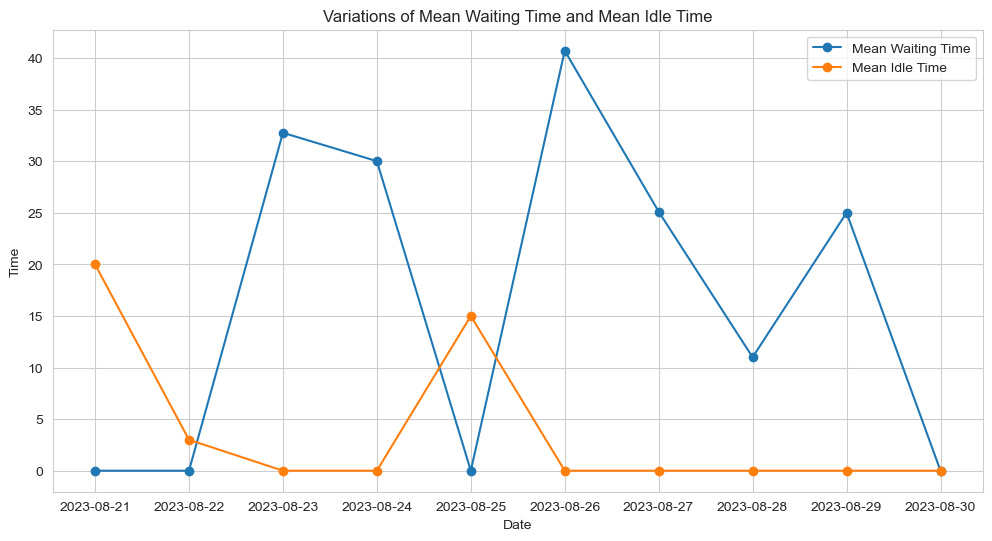

In [488]:
# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(df, lambda_cost, rho_cost, no_show_history, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)



In [ ]:
# Tracer les boxplots des temps d'attente et des temps morts
plot_boxplots(results_data)



In [ ]:
# Tracer les variations entre X et Y*
#plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

# Tracer le boxplot pour mesurer la dispersion entre X et Y*
plot_dispersion_boxplot(no_show_vs_overbooking_data)

## uniform distribution

In [307]:
from scipy.stats import norm
import matplotlib.pyplot as plt

def calculate_critical_fractile(lambda_cost, rho_cost):
    return lambda_cost / (lambda_cost + rho_cost)

def calculate_optimal_overbooking_level(F_Y, mean, std_dev):
    Y_star = norm.ppf(F_Y, loc=mean, scale=std_dev)
    return round(Y_star)

def calculate_I(X, Y, service_times):
    sum_X = np.sum(service_times[:X])
    sum_Y = np.sum(service_times[:Y])
    I = max(0, sum_X - sum_Y)
    return I

def calculate_W(X, Y, service_times):
    sum_X = np.sum(service_times[:X])
    sum_Y = np.sum(service_times[:Y])
    W = max(0, sum_Y - sum_X)
    return W

def calculate_mean_I_W(X, Y, service_times):
    I = calculate_I(X, Y, service_times)
    W = calculate_W(X, Y, service_times)
    mean_I = I / abs(X - Y) if abs(X - Y) > 0 else 0
    mean_W = W / abs(X - Y) if abs(X - Y) > 0 else 0
    return mean_I, mean_W

# Fonction pour traiter les N derniers jours pour un sta3n donné
def process_last_n_days(data, lambda_cost, rho_cost, m, s, sta3n=657, num_days=10):
    data = data.sort_values(by='activitydatetime')
    # Filtrer par sta3n
    data = data[data['sta3n'] == sta3n]
    
    # Sélectionner les N derniers jours
    last_n_days = data['activitydatetime'].dt.date.unique()[-num_days:]
    
    # Filtrer le DataFrame pour ces N jours
    data_last_n_days = data[data['activitydatetime'].dt.date.isin(last_n_days)]
    # Trier par ordre décroissant selon la date
    data_last_n_days = data_last_n_days.sort_values(by='activitydatetime', ascending=False)

    # Initialiser une liste pour stocker les résultats
    results = []
    no_show_vs_overbooking = []

    for day in last_n_days:
        day_data = data_last_n_days[data_last_n_days['activitydatetime'].dt.date == day]
        
        # Nombre de No-show
        X = day_data['NoShow'].sum()

        # Calculer F(Y) pour la journée
        F_Y = calculate_critical_fractile(lambda_cost, rho_cost)

        # Calculer Y* pour la journée
        Y_star = calculate_optimal_overbooking_level(F_Y, m, s)

        # Extraire les temps de service
        service_times = day_data['service_time'].values

        # Calculer les valeurs moyennes de I et W
        mean_I, mean_W = calculate_mean_I_W(X, Y_star, service_times)

        # Ajouter la variation X et Y
        no_show_vs_overbooking.append({'date': day, 'X': X, 'Y_star': Y_star, 'diff': abs(X - Y_star)})

        # Ajouter les résultats à la liste
        results.append({'date': day, 'mean_I': mean_I, 'mean_W': mean_W})

    # Convertir les résultats en DataFrame pour analyse
    results_data = pd.DataFrame(results)
    no_show_vs_overbooking_data = pd.DataFrame(no_show_vs_overbooking)

    return results_data, no_show_vs_overbooking_data

# Fonction pour tracer les variations de Waiting Time et Idle Time
def plot_variations(results_data):
    plt.figure(figsize=(12, 6))
    plt.plot(results_data['date'], results_data['mean_W'], marker='o', label='Mean Waiting Time')
    plt.plot(results_data['date'], results_data['mean_I'], marker='o', label='Mean Idle Time')
    plt.xlabel('Date')
    plt.ylabel('Time')
    plt.title('Variations of Mean Waiting Time and Mean Idle Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer les boxplots de Waiting Time et Idle Time
def plot_boxplots(results_data):
    plt.figure(figsize=(12, 6))
    
    # Boxplot pour Mean Waiting Time
    plt.subplot(1, 2, 1)
    plt.boxplot(results_data['mean_W'], patch_artist=True)
    plt.title('Boxplot of Mean Waiting Time')
    plt.ylabel('Time')
    
    # Boxplot pour Mean Idle Time
    plt.subplot(1, 2, 2)
    plt.boxplot(results_data['mean_I'], patch_artist=True)
    plt.title('Boxplot of Mean Idle Time')
    
    plt.show()

# Fonction pour tracer les variations entre No-show X et Y_star
def plot_no_show_vs_overbooking(no_show_vs_overbooking_data):
    plt.figure(figsize=(12, 6))
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['X'], marker='o', label='No-show (X)', color='blue')
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['Y_star'], marker='o', label='Optimal Overbooking (Y*)', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Number')
    plt.title('Variations of No-show (X) vs Optimal Overbooking Y*')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer les boxplots de la dispersion moyenne entre X et Y
def plot_dispersion_boxplot(no_show_vs_overbooking_data):
    plt.figure(figsize=(6, 6))
    plt.boxplot(no_show_vs_overbooking_data['diff'], patch_artist=True)
    plt.title('Boxplot of Dispersion between X and Y*')
    plt.ylabel('Difference |X - Y*|')
    plt.show()


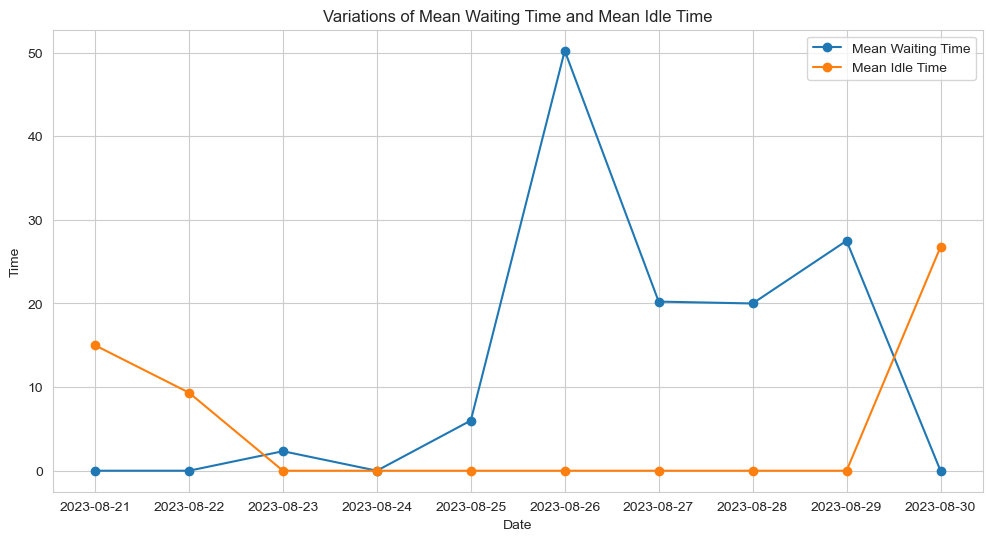

In [309]:
# Exemple d'utilisation
lambda_cost = 2
rho_cost = 1
sta3n = 657
num_days = 10 


df['activitydatetime'] = pd.to_datetime(df['activitydatetime'])

# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(df, lambda_cost, rho_cost, m, s, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)

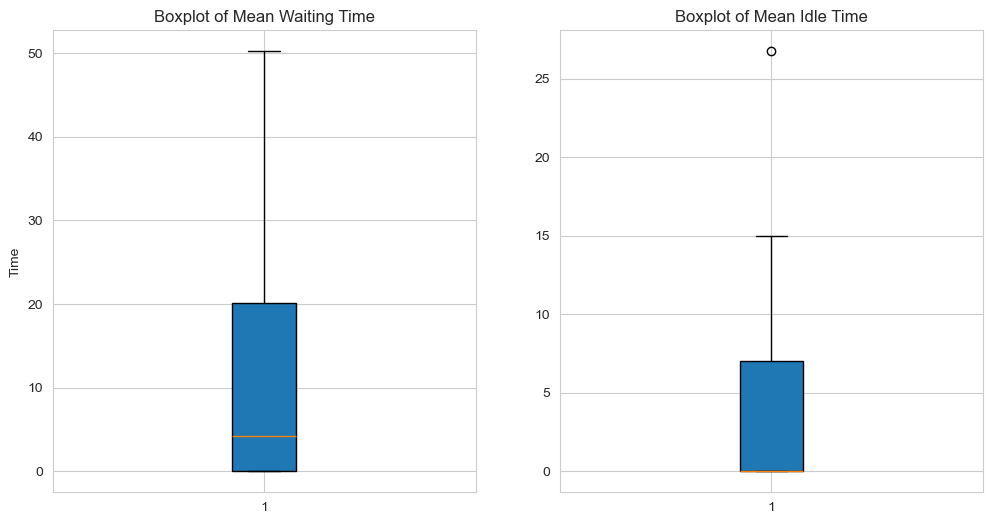

In [310]:
# Tracer les boxplots des temps d'attente et des temps morts
plot_boxplots(results_data)

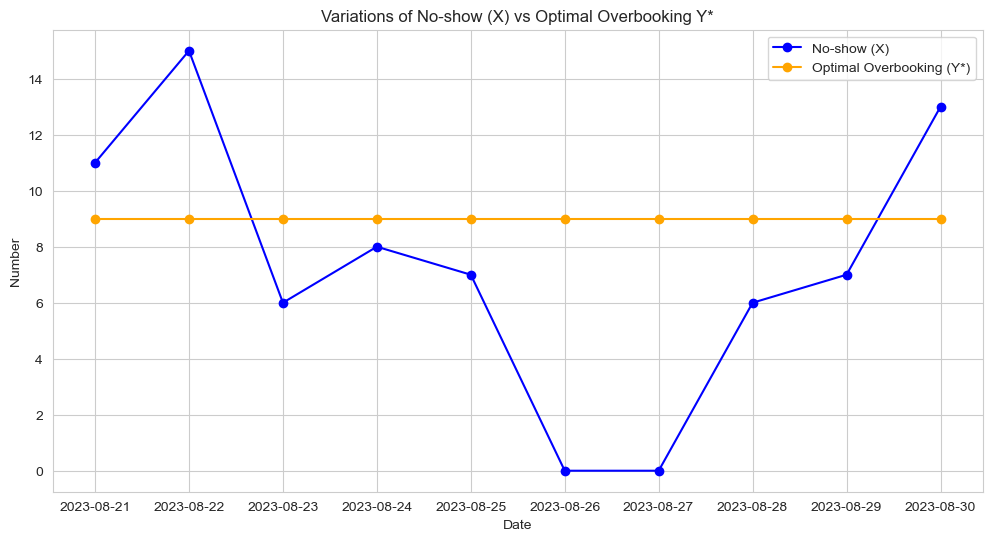

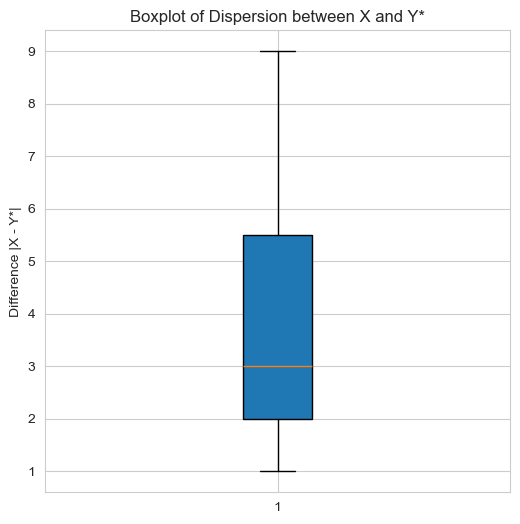

In [311]:
# Tracer les variations entre No-show X et Optimal Overbooking Y_star
plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

# Tracer le boxplot de la dispersion moyenne entre X et Y_star
plot_dispersion_boxplot(no_show_vs_overbooking_data)

## generic distribution

In [313]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Fonction pour calculer la critical fractile
def calculate_critical_fractile(lambda_cost, rho_cost):
    return lambda_cost / (lambda_cost + rho_cost)

# Fonction pour calculer le niveau optimal d'overbooking en utilisant la méthode générique
def generic_calculate_optimal_overbooking_level(F_Y, no_show_history):
    """
    Calcule le niveau optimal d'overbooking Y* en fonction de la critical fractile F_Y
    et des probabilités cumulées dans no_show_history.

    Parameters:
    - F_Y: float, la critical fractile.
    - no_show_history: DataFrame, historique des No-show avec une colonne 'no_show_count' et 'cumulative_probability'.

    Returns:
    - Y_star: int, le niveau optimal d'overbooking.
    """
    # Trier les No-shows par nombre croissant
    sorted_no_shows = no_show_history.sort_values(by='no_show_count')
    
    # Calculer les probabilités cumulées
    sorted_no_shows['cumulative_probability'] = sorted_no_shows['no_show_count'].cumsum() / sorted_no_shows['no_show_count'].sum()
    
    # Trouver le nombre de No-show dont la probabilité cumulée est la plus proche de F_Y
    Y_star = sorted_no_shows.iloc[(sorted_no_shows['cumulative_probability'] - F_Y).abs().argsort()[:1]]['no_show_count'].values[0]
    
    return Y_star

# Fonction pour calculer les temps morts (Idle Time)
def calculate_I(X, Y, service_times):
    sum_X = np.sum(service_times[:X])
    sum_Y = np.sum(service_times[:Y])
    I = max(0, sum_X - sum_Y)
    return I

# Fonction pour calculer les temps d'attente (Waiting Time)
def calculate_W(X, Y, service_times):
    sum_X = np.sum(service_times[:X])
    sum_Y = np.sum(service_times[:Y])
    W = max(0, sum_Y - sum_X)
    return W

# Fonction pour calculer les moyennes des temps morts et temps d'attente
def calculate_mean_I_W(X, Y, service_times):
    I = calculate_I(X, Y, service_times)
    W = calculate_W(X, Y, service_times)
    mean_I = I / abs(X - Y) if abs(X - Y) > 0 else 0
    mean_W = W / abs(X - Y) if abs(X - Y) > 0 else 0
    return mean_I, mean_W

# Fonction pour traiter les N derniers jours pour un sta3n donné
def process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n=657, num_days=10):
    data = data.sort_values(by='activitydatetime')
    
    # Filtrer par sta3n
    data = data[data['sta3n'] == sta3n]
    
    # Sélectionner les N derniers jours
    last_n_days = data['activitydatetime'].dt.date.unique()[-num_days:]
    
    # Filtrer le DataFrame pour ces N jours
    data_last_n_days = data[data['activitydatetime'].dt.date.isin(last_n_days)]
    
    # Trier par ordre décroissant selon la date
    data_last_n_days = data_last_n_days.sort_values(by='activitydatetime', ascending=False)
    
    # Initialiser une liste pour stocker les résultats
    results = []
    no_show_vs_overbooking = []

    for day in last_n_days:
        day_data = data_last_n_days[data_last_n_days['activitydatetime'].dt.date == day]
        
        # Nombre de No-show
        X = day_data['NoShow'].sum()

        # Calculer F(Y) pour la journée
        F_Y = calculate_critical_fractile(lambda_cost, rho_cost)

        # Calculer Y* pour la journée en utilisant les probabilités cumulées
        Y_star = generic_calculate_optimal_overbooking_level(F_Y, no_show_history)

        # Extraire les temps de service
        service_times = day_data['service_time'].values

        # Calculer les valeurs moyennes de I et W
        mean_I, mean_W = calculate_mean_I_W(X, Y_star, service_times)

        # Ajouter la variation X et Y
        no_show_vs_overbooking.append({'date': day, 'X': X, 'Y_star': Y_star, 'diff': abs(X - Y_star)})

        # Ajouter les résultats à la liste
        results.append({'date': day, 'mean_I': mean_I, 'mean_W': mean_W})

    # Convertir les résultats en DataFrame pour analyse
    results_data = pd.DataFrame(results)
    no_show_vs_overbooking_data = pd.DataFrame(no_show_vs_overbooking)

    return results_data, no_show_vs_overbooking_data

# Fonction pour tracer les variations de Waiting Time et Idle Time
def plot_variations(results_data):
    plt.figure(figsize=(12, 6))
    plt.plot(results_data['date'], results_data['mean_W'], marker='o', label='Mean Waiting Time')
    plt.plot(results_data['date'], results_data['mean_I'], marker='o', label='Mean Idle Time')
    plt.xlabel('Date')
    plt.ylabel('Time')
    plt.title('Variations of Mean Waiting Time and Mean Idle Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer les boxplots de Waiting Time et Idle Time
def plot_boxplots(results_data):
    plt.figure(figsize=(12, 6))
    
    # Boxplot pour Mean Waiting Time
    plt.subplot(1, 2, 1)
    plt.boxplot(results_data['mean_W'], patch_artist=True)
    plt.title('Boxplot of Mean Waiting Time')
    plt.ylabel('Time')
    
    # Boxplot pour Mean Idle Time
    plt.subplot(1, 2, 2)
    plt.boxplot(results_data['mean_I'], patch_artist=True)
    plt.title('Boxplot of Mean Idle Time')
    
    plt.show()

# Fonction pour tracer les variations entre No-show X et Y_star
def plot_no_show_vs_overbooking(no_show_vs_overbooking_data):
    plt.figure(figsize=(12, 6))
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['X'], marker='o', label='No-show (X)', color='blue')
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['Y_star'], marker='o', label='Optimal Overbooking (Y*)', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Number')
    plt.title('Variations of No-show (X) vs Optimal Overbooking Y*')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer les boxplots de la dispersion moyenne entre X et Y
def plot_dispersion_boxplot(no_show_vs_overbooking_data):
    plt.figure(figsize=(6, 6))
    plt.boxplot(no_show_vs_overbooking_data['diff'], patch_artist=True)
    plt.title('Boxplot of Dispersion between X and Y*')
    plt.ylabel('Difference |X - Y*|')
    plt.show()

# Exemple d'utilisation
lambda_cost = 100
rho_cost = 50
sta3n = 657
num_days = 10  # Vous pouvez changer ce nombre selon vos besoins

# Supposez que no_show_history a été pré-calculé et contient les probabilités cumulées
# no_show_history est un DataFrame avec des colonnes 'no_show_count' et 'cumulative_probability'

# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)

# Tracer les boxplots des temps d'attente et des temps morts
plot_boxplots(results_data)

# Tracer les variations entre X et Y*
plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

# Tracer le boxplot pour mesurer la dispersion entre X et Y*
plot_dispersion_boxplot(no_show_vs_overbooking_data)


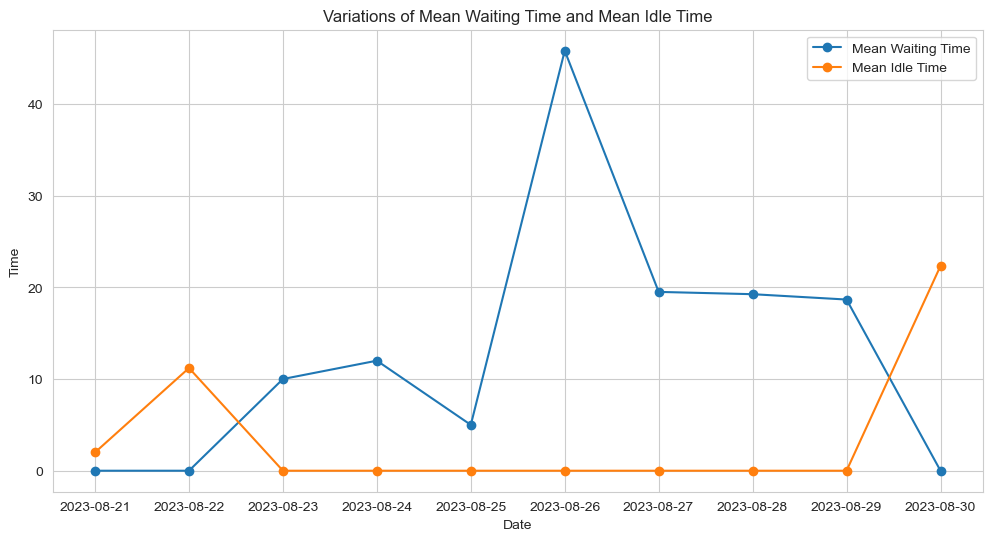

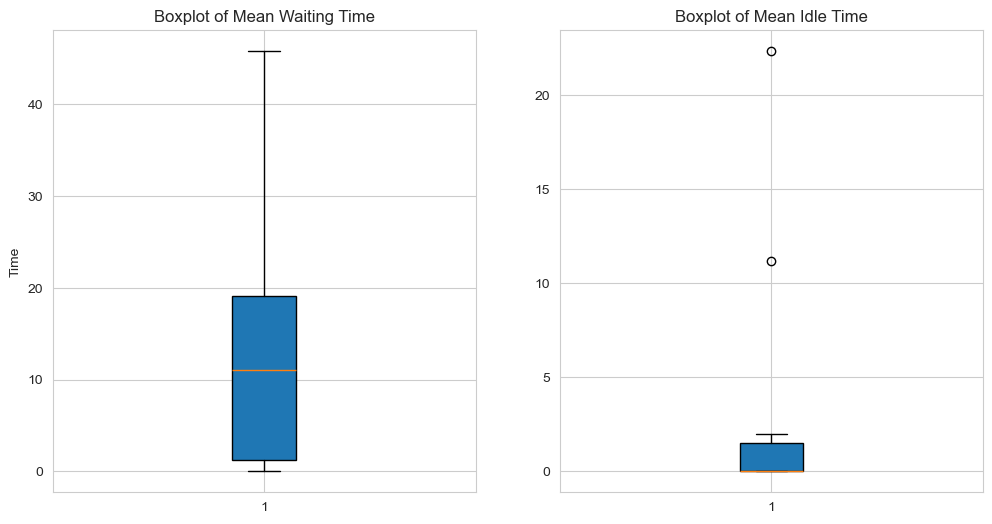

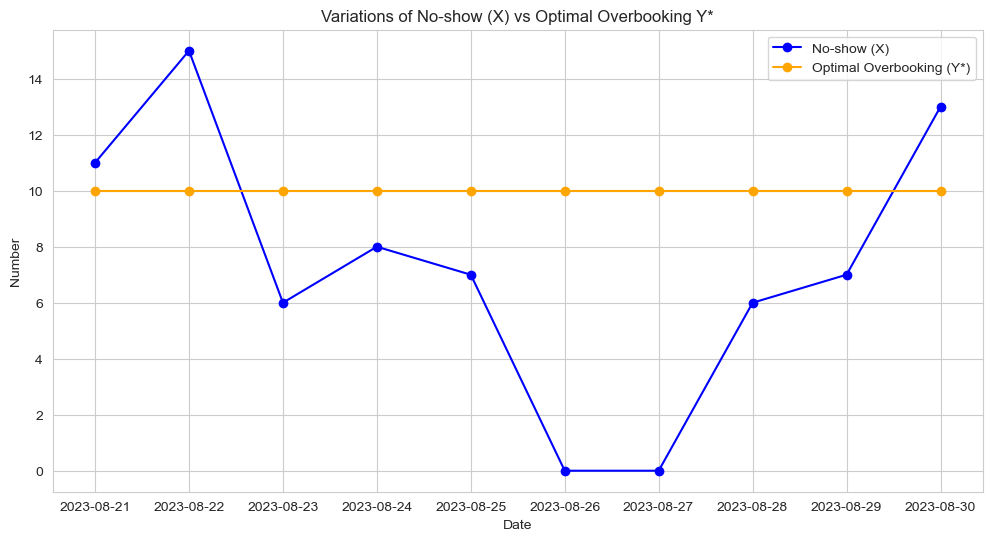

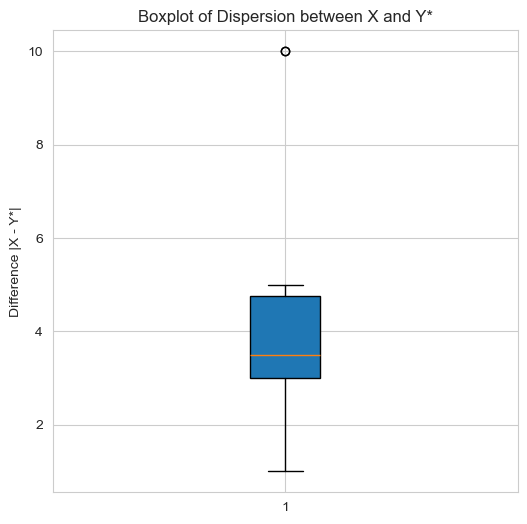

In [315]:
lambda_cost = 2
rho_cost = 1
sta3n = 657
num_days = 10  

# Supposez que no_show_history a été pré-calculé et contient les probabilités cumulées
# no_show_history est un DataFrame avec des colonnes 'no_show_count' et 'cumulative_probability'

# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(df, lambda_cost, rho_cost, no_show_history, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)

# Tracer les boxplots des temps d'attente et des temps morts
plot_boxplots(results_data)

# Tracer les variations entre X et Y*
plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

# Tracer le boxplot pour mesurer la dispersion entre X et Y*
plot_dispersion_boxplot(no_show_vs_overbooking_data)

# Simulation

NameError: name 'data' is not defined

In [173]:
# Prédiction

In [410]:
# Filtrer les données pour le 30/08/2023
data_filtered = data[data['activitydatetime'].str.contains("2023-08-30")]

# Trouver le stopcode avec le plus de rendez-vous
most_common_stopcode = data_filtered['sta3n'].value_counts().idxmax()

# Filtrer le DataFrame pour ce stopcode spécifique
data_sta3n = data_filtered[data_filtered['sta3n'] == most_common_stopcode]

###################

# Convertir la colonne 'activitydatetime' en format datetime si ce n'est pas déjà fait
df['activitydatetime'] = pd.to_datetime(df['activitydatetime'])

# Définir la date de référence (dernier jour) et calculer la date de début (10 jours avant)
end_date = df['activitydatetime'].max()  # ou remplacer par une date spécifique
start_date = end_date - pd.Timedelta(days=10)

# Filtrer les données pour les 10 derniers jours
data_filtered = df[(df['activitydatetime'] >= start_date) & (df['activitydatetime'] <= end_date)]

# Trouver le stopcode avec le plus de rendez-vous dans ces 10 jours
most_common_stopcode = data_filtered['sta3n'].value_counts().idxmax()

# Filtrer le dataFrame pour ce stopcode spécifique
data_sta3n = data_filtered[data_filtered['sta3n'] == most_common_stopcode]

##################################"

def filter_data_by_date_and_stopcode(data, date_str, stopcode):
    """
    Filtre les données pour une date spécifique et un stopcode donné.

    Parameters:
    - data: dataFrame contenant les données initiales.
    - date_str: str, la date à filtrer sous forme de chaîne (format 'YYYY-MM-DD').
    - stopcode: int, le stopcode spécifique pour lequel filtrer les données.

    Returns:
    - data_stopcode: dataFrame filtré pour le stopcode et la date spécifiés.
    """
    # Filtrer les données pour la date spécifiée
    data_filtered = data[data['activitydatetime'].str.contains(date_str)]
    
    # Filtrer le dataFrame pour le stopcode spécifique
    data_stopcode = data_filtered[data_filtered['stopcode'] == stopcode]
    
    return data_stopcode
#data_stopcode = filter_data_by_date_and_stopcode(data, "2023-08-30", 301)

####################################"



In [412]:
#data_stopcode = data_stopcode.sort_values(by='activitydatetime', ascending=True)

In [413]:
data_sta3n

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,NoShow,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg
2006992,10683380,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,MISSOURI,0,0,1,1,29,8,19,23,0.0,10.500000
2007339,10684474,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,MISSOURI,0,0,1,3,24,8,21,26,0.0,12.666667
2007411,10684734,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,MISSOURI,1,0,1,0,21,8,15,120,0.0,2.000000
2007421,10684765,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,KANSAS,0,0,0,2,30,8,14,35,0.0,4.500000
2007509,10684967,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,MISSOURI,0,0,1,4,25,8,14,39,0.0,14.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11341458,1604948062,2023-08-29 16:55:24,589,502,0.0,1,0,660.0,KANSAS,0,0,1,1,29,8,16,11,0.0,14.000000
11341500,1604950258,2023-08-30 15:16:37,589,301,10.0,28,0,660.0,KANSAS,1,0,0,2,30,8,15,8,0.0,14.000000
11341769,1604964585,2023-08-23 13:50:24,589,510,0.0,0,0,655.0,MISSOURI,0,0,1,2,23,8,13,1,0.0,14.000000
11342009,1604979330,2023-08-28 07:49:29,589,304,0.0,0,1,675.0,KANSAS,0,0,1,0,28,8,7,3,0.0,14.000000


In [414]:
data = data_sta3n

In [415]:
data

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,NoShow,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg
2006992,10683380,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,MISSOURI,0,0,1,1,29,8,19,23,0.0,10.500000
2007339,10684474,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,MISSOURI,0,0,1,3,24,8,21,26,0.0,12.666667
2007411,10684734,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,MISSOURI,1,0,1,0,21,8,15,120,0.0,2.000000
2007421,10684765,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,KANSAS,0,0,0,2,30,8,14,35,0.0,4.500000
2007509,10684967,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,MISSOURI,0,0,1,4,25,8,14,39,0.0,14.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11341458,1604948062,2023-08-29 16:55:24,589,502,0.0,1,0,660.0,KANSAS,0,0,1,1,29,8,16,11,0.0,14.000000
11341500,1604950258,2023-08-30 15:16:37,589,301,10.0,28,0,660.0,KANSAS,1,0,0,2,30,8,15,8,0.0,14.000000
11341769,1604964585,2023-08-23 13:50:24,589,510,0.0,0,0,655.0,MISSOURI,0,0,1,2,23,8,13,1,0.0,14.000000
11342009,1604979330,2023-08-28 07:49:29,589,304,0.0,0,1,675.0,KANSAS,0,0,1,0,28,8,7,3,0.0,14.000000


In [416]:
data.drop(['patientsid'], axis = True, inplace=True)

<a name="3.2.3"></a>
3.2.3 - data Standardization/normalisation

In [417]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
data['state'] = label_encoder.fit_transform(data['state'])

In [418]:
# Division des données en ensembles d'entraînement et de test
X = data.drop('NoShow', axis=1)
y = data['NoShow']

In [419]:
X_init = X.copy()

In [420]:
X.drop('activitydatetime', axis=1, inplace=True)
#del daily_no_show

In [421]:
y.value_counts()

NoShow
0    1672
1      88
Name: count, dtype: int64

In [422]:
from sklearn.preprocessing import MinMaxScaler

# Initialiser le MinMaxScaler
# Normalisation des données après le sampling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

<a name="4"></a>
## 4 - Modeling

In [423]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from joblib import dump, load
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

<a name="4"></a>
## 4 - Ada Boost

<a name="4.1.1"></a>
### 4.1.1 - Training model

In [424]:
# Chargement du modèle
rf_model = load('rf_model_NoShow_final.joblib')
print("Paramètres du modèle de Random Forest:")
print(rf_model.get_params())

Paramètres du modèle de Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': True, 'warm_start': False}


In [425]:
#dump(best_model, 'rf_model_NoShow_final.joblib')
#print("Modèle enregistré avec succès.")

In [426]:
y_proba_rf = rf_model.predict_proba(X)[:, 1]
y_pred_rf = rf_model.predict(X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [427]:
threshold = 0.5
title_rf = "Random Forest AUC"

<a name="4.1.2"></a>
### 4.1.2 - Evaluation

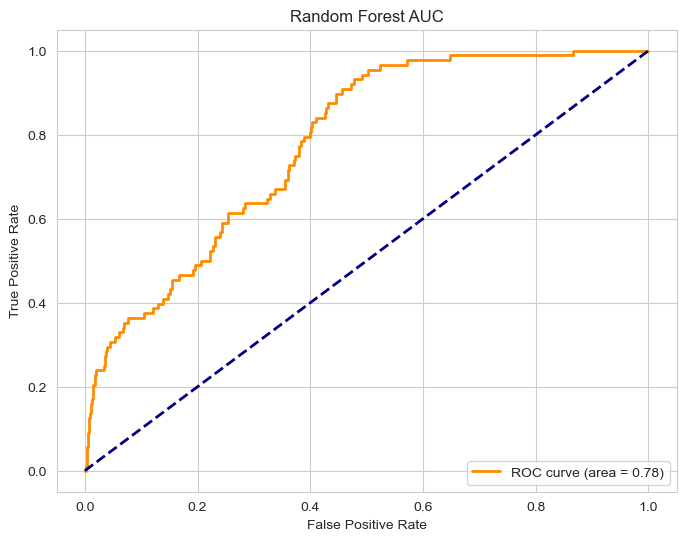

In [429]:
plot_roc_curve(y, y_proba_rf, model_name=title_rf)

In [430]:
def evaluate_tree_ensemble_model(X_test, y_test, y_test_proba, y_test_pred):
    """
    Evaluate the tree ensemble model by calculating performance metrics and displaying both confusion matrices and a table of metrics.

    Args:
        model: Trained tree ensemble model (e.g., RandomForest, XGBoost).
        X_train, y_train: Training data and labels.
        X_test, y_test: Testing data and labels.
    """
    # Predict classes and probabilities

    # Display confusion matrices
    cm_test = confusion_matrix(y_test, y_test_pred)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_test, annot=True, fmt="d", ax=ax[1], cmap="Blues")
    ax[1].set_title("Confusion Matrix (Test)")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")
    plt.show()

    # Calculate metrics
    metrics = {
        'Metric': ['Recall', 'AUC', 'Accuracy', 'Precision', 'F1 Score'],
        'Test': [
            recall_score(y_test, y_test_pred, average='macro'),
            roc_auc_score(y_test, y_test_proba),
            accuracy_score(y_test, y_test_pred),
            precision_score(y_test, y_test_pred, average='macro'),
            f1_score(y_test, y_test_pred, average='macro')
        ]
    }

    # Create a dataFrame for displaying
    results_data = pd.DataFrame(metrics)
    print(results_data.set_index('Metric'))


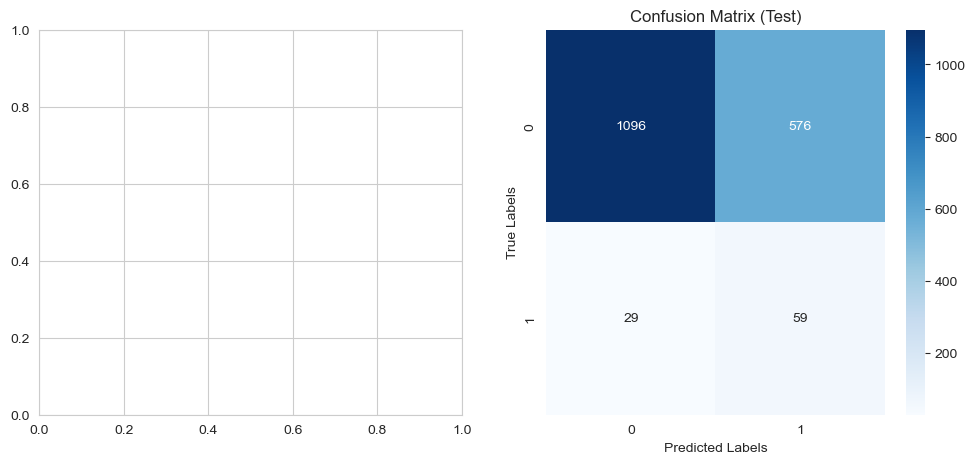

               Test
Metric             
Recall     0.662978
AUC        0.779510
Accuracy   0.656250
Precision  0.533568
F1 Score   0.473453


In [431]:
resultat_rf = evaluate_tree_ensemble_model(X, y, y_proba_rf, y_pred_rf)

In [432]:
def concatenate_results(X, y, y_pred, y_pred_column_name='y_pred'):
    """
    Concatène le dataFrame X_inti, la série y, et le tableau de prédictions y_pred en un seul dataFrame.

    Parameters:
    - X_inti: dataFrame original contenant les caractéristiques.
    - y: Série ou dataFrame contenant les étiquettes réelles.
    - y_pred: ndarray contenant les prédictions du modèle.
    - y_pred_column_name: str, nom de la colonne pour les prédictions.

    Returns:
    - dataFrame combiné contenant X_inti, y et y_pred.
    """
    # Assurez-vous que y et y_pred ont la même longueur
    if len(y) != len(y_pred):
        raise ValueError("La longueur de y et y_pred doit être identique.")
    
    # Convertir y_pred en dataFrame pour concaténation
    y_pred_data = pd.DataFrame(y_pred, columns=[y_pred_column_name])
    
    # Concaténer X_inti, y, et y_pred
    combined_data = pd.concat([X.reset_index(drop=True), 
                             y.reset_index(drop=True), 
                             y_pred_data.reset_index(drop=True)], axis=1)
    
    return combined_data


In [433]:
data_ns_predicted = concatenate_results(X_init, y, y_proba_rf, y_pred_column_name='predicted_NoShow')

In [434]:
data_ns_predicted[(data_ns_predicted['NoShow'] == 1) & (data_ns_predicted['predicted_NoShow']  >  0.5)]

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow
2,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,0,1,0,21,8,15,120,0.00,2.000000,1,0.765735
21,2023-08-25 09:56:46,589,212,48.0,12,1,647.0,11,0,1,4,25,8,9,36,0.00,11.000000,1,0.506590
40,2023-08-22 09:23:55,589,160,9.0,16,0,641.0,11,0,1,1,22,8,9,25,0.00,6.000000,1,0.874310
51,2023-08-25 08:56:07,589,303,1.0,0,0,661.0,7,0,1,4,25,8,8,0,0.00,8.000000,1,0.535523
81,2023-08-21 11:49:11,589,502,34.0,0,0,785.0,17,0,1,0,21,8,11,64,0.00,10.000000,1,0.916473
107,2023-08-23 08:50:27,589,502,1.0,43,0,650.0,11,0,1,2,23,8,8,19,0.25,24.000000,1,0.824855
113,2023-08-24 09:26:48,589,502,1.0,4,0,655.0,11,0,1,3,24,8,9,16,0.00,0.000000,1,0.659231
125,2023-08-25 09:01:21,589,303,33.0,0,0,650.0,11,0,1,4,25,8,9,14,0.00,14.000000,1,0.810597
129,2023-08-22 12:54:23,589,334,5.0,8,1,655.0,11,0,1,1,22,8,12,9,0.00,1.000000,1,0.850075
153,2023-08-25 15:46:18,589,150,14.0,18,1,655.0,11,0,1,4,25,8,15,10,0.20,23.600000,1,0.695847


In [435]:
data_ns_predicted[data_ns_predicted['predicted_NoShow']  > 0.5].head(50)

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow
1,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,11,0,1,3,24,8,21,26,0.000000,12.666667,0,0.569094
2,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,0,1,0,21,8,15,120,0.000000,2.000000,1,0.765735
7,2023-08-28 13:03:16,589,436,2.0,33,1,660.0,7,0,1,0,28,8,13,5,0.000000,12.000000,0,0.703635
10,2023-08-28 10:39:23,589,303,1.0,0,0,672.0,7,0,1,0,28,8,10,0,0.000000,3.500000,0,0.750232
12,2023-08-22 10:44:10,589,307,1.0,3,0,661.0,7,0,1,1,22,8,10,8,0.000000,25.000000,0,0.755022
18,2023-08-22 11:02:01,589,303,1.0,0,0,666.0,7,0,1,1,22,8,11,0,0.000000,5.000000,0,0.759069
21,2023-08-25 09:56:46,589,212,48.0,12,1,647.0,11,0,1,4,25,8,9,36,0.000000,11.000000,1,0.506590
25,2023-08-21 15:32:55,589,180,1.0,4,1,666.0,7,0,1,0,21,8,15,79,0.000000,33.333333,0,0.742160
28,2023-08-28 14:49:39,589,160,4.0,53,0,640.0,11,0,1,0,28,8,14,3,0.000000,22.250000,0,0.660833
30,2023-08-21 14:00:57,589,150,0.0,3,1,653.0,11,0,1,0,21,8,14,10,0.000000,10.857143,0,0.509225


In [436]:
# Filtrer les cas où la probabilité de no-show est inférieure à 0.5
data_low_proba_noshow  = data_ns_predicted[data_ns_predicted['predicted_NoShow'] < 0.5].copy()

In [437]:
data_low_proba_noshow

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow
0,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,11,0,1,1,29,8,19,23,0.0,10.50,0,0.455000
3,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,7,0,0,2,30,8,14,35,0.0,4.50,0,0.406548
4,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,11,0,1,4,25,8,14,39,0.0,14.25,0,0.039662
5,2023-08-30 08:36:02,589,307,0.0,3,0,661.0,7,0,1,2,30,8,8,16,0.0,3.00,0,0.062954
6,2023-08-28 18:27:27,589,304,0.0,4,0,640.0,11,0,1,0,28,8,18,35,0.0,1.00,0,0.060018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,2023-08-25 15:08:08,589,304,0.0,5,0,657.0,11,0,1,4,25,8,15,4,0.0,14.00,0,0.026974
1755,2023-08-29 16:55:24,589,502,0.0,1,0,660.0,7,0,1,1,29,8,16,11,0.0,14.00,0,0.022523
1756,2023-08-30 15:16:37,589,301,10.0,28,0,660.0,7,0,0,2,30,8,15,8,0.0,14.00,1,0.377751
1757,2023-08-23 13:50:24,589,510,0.0,0,0,655.0,11,0,1,2,23,8,13,1,0.0,14.00,0,0.107498


In [438]:
X = data_low_proba_noshow.drop('service_time', axis=1) 
y = data_low_proba_noshow['service_time']

In [439]:
X = X.drop(columns=['NoShow', 'predicted_NoShow'], axis = 1)

In [440]:
from sklearn.preprocessing import MinMaxScaler
# Initialiser le MinMaxScaler
# Normalisation des données après le sampling
scaler = MinMaxScaler()
X = scaler.fit_transform(X.drop('activitydatetime', axis=1))

In [441]:
from keras.models import load_model
# Charge le modèle
best_ann_st = load_model('modele_st_mlp_v6.keras')
print("Modèle chargé avec succès.")

Modèle chargé avec succès.


In [442]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.utils import shuffle

In [443]:
# Make predictions
y_pred_ann = best_ann_st.predict(X).flatten()  # Flatten is used to match the shape of y_test

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [444]:
y_pred_ann

array([11.149415, 14.528857, 18.946194, ..., 21.545639, 18.946194,
       17.790144], dtype=float32)

In [445]:
def evaluate_mlp_model(model, X_test, y_test, y_pred):
    """
    Evaluate an MLP model using R-squared, MAE, MSE, and RMSE.

    Args:
    model: The trained MLP model.
    X_test: Test features.
    y_test: True values for test features.

    Returns:
    dict: A dictionary containing evaluation metrics.
    """
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return {
        'R-squared': r2,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
    
}

In [446]:
evaluate_mlp_model(best_ann_st, X, y, y_pred_ann)

{'R-squared': -0.013472568484237168,
 'Mean Absolute Error': 18.597979124281142,
 'Mean Squared Error': 899.7096803034214,
 'Root Mean Squared Error': 29.995160948116638}

In [447]:
# Ajouter les prédictions dans le dataFrame filtré
data_low_proba_noshow['predicted_service_time'] = y_pred_ann

# Mettre à jour la colonne 'predicted_service_time' dans le dataFrame original
data_ns_predicted['predicted_service_time'] = 0  # Initialiser à 0 pour tous les cas
data_ns_predicted.loc[data_low_proba_noshow.index, 'predicted_service_time'] = data_low_proba_noshow['predicted_service_time']

In [448]:
data_ns_predicted

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow,predicted_service_time
0,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,11,0,1,1,29,8,19,23,0.0,10.500000,0,0.455000,11.149415
1,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,11,0,1,3,24,8,21,26,0.0,12.666667,0,0.569094,0.000000
2,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,0,1,0,21,8,15,120,0.0,2.000000,1,0.765735,0.000000
3,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,7,0,0,2,30,8,14,35,0.0,4.500000,0,0.406548,14.528857
4,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,11,0,1,4,25,8,14,39,0.0,14.250000,0,0.039662,18.946194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,2023-08-29 16:55:24,589,502,0.0,1,0,660.0,7,0,1,1,29,8,16,11,0.0,14.000000,0,0.022523,18.946194
1756,2023-08-30 15:16:37,589,301,10.0,28,0,660.0,7,0,0,2,30,8,15,8,0.0,14.000000,1,0.377751,21.545639
1757,2023-08-23 13:50:24,589,510,0.0,0,0,655.0,11,0,1,2,23,8,13,1,0.0,14.000000,0,0.107498,18.946194
1758,2023-08-28 07:49:29,589,304,0.0,0,1,675.0,7,0,1,0,28,8,7,3,0.0,14.000000,0,0.127501,17.790144


In [449]:
data_ns_predicted[data_ns_predicted['NoShow'] == 1]

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow,predicted_service_time
2,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,0,1,0,21,8,15,120,0.0,2.0,1,0.765735,0.000000
21,2023-08-25 09:56:46,589,212,48.0,12,1,647.0,11,0,1,4,25,8,9,36,0.0,11.0,1,0.506590,0.000000
24,2023-08-30 08:06:45,589,304,8.0,1,0,641.0,11,0,1,2,30,8,8,5,0.0,8.8,1,0.471836,22.609501
40,2023-08-22 09:23:55,589,160,9.0,16,0,641.0,11,0,1,1,22,8,9,25,0.0,6.0,1,0.874310,0.000000
51,2023-08-25 08:56:07,589,303,1.0,0,0,661.0,7,0,1,4,25,8,8,0,0.0,8.0,1,0.535523,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,2023-08-30 20:11:53,589,436,35.0,8,0,662.0,7,0,1,2,30,8,20,36,0.0,14.0,1,0.480003,22.272976
1717,2023-08-21 08:43:06,589,304,77.0,0,0,641.0,11,0,1,0,21,8,8,0,0.0,14.0,1,0.965407,0.000000
1741,2023-08-22 13:39:57,589,436,83.0,2,0,665.0,7,0,1,1,22,8,13,8,0.0,14.0,1,0.954956,0.000000
1751,2023-08-30 14:13:19,589,160,17.0,13,0,665.0,7,0,1,2,30,8,14,29,0.0,14.0,1,0.407500,18.946194


In [450]:
# Fonction pour enregistrer un dataFrame en CSV dans le répertoire 'preprocessed'
def save_dataframe(data, name):
    filename = f'data_simulation/{name}.csv'
    data.to_csv(filename, index=False)


In [451]:
data_ns_predicted = data_ns_predicted.sort_values(by='activitydatetime', ascending=True)

In [452]:
# Liste des colonnes à formater
columns_to_format = ['predicted_NoShow', 'predicted_service_time', 'prior_noShow_rate', 'prior_service_time_avg']

# Appliquer le formatage à deux chiffres après la virgule
data_ns_predicted[columns_to_format] = data_ns_predicted[columns_to_format].round(2)

In [453]:
save_dataframe(data_ns_predicted, 'data_10_days')

In [454]:
data_ns_predicted

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow,predicted_service_time
978,2023-08-21 00:49:36,589,322,5.0,17,0,666.0,7,0,0,0,21,8,0,1,0.0,19.17,0,0.39,21.16
1379,2023-08-21 02:10:35,589,502,1.0,40,1,674.0,7,0,1,0,21,8,2,8,0.0,13.50,0,0.70,0.00
1027,2023-08-21 05:18:40,589,436,14.0,76,1,641.0,11,0,1,0,21,8,5,6,0.0,16.33,0,0.61,0.00
1487,2023-08-21 06:11:30,589,323,1.0,7,1,634.0,11,0,0,0,21,8,6,17,0.0,29.57,0,0.74,0.00
390,2023-08-21 07:16:37,589,334,0.0,3,0,645.0,11,0,1,0,21,8,7,17,0.0,29.60,0,0.08,24.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,2023-08-30 19:54:26,589,305,1.0,7,0,640.0,11,0,1,2,30,8,19,2,0.0,14.00,0,0.45,22.73
1039,2023-08-30 19:56:47,589,150,0.0,29,1,654.0,11,0,1,2,30,8,19,10,0.0,3.00,0,0.13,11.15
1712,2023-08-30 20:11:53,589,436,35.0,8,0,662.0,7,0,1,2,30,8,20,36,0.0,14.00,1,0.48,22.27
1217,2023-08-30 20:19:44,589,307,24.0,7,1,655.0,11,0,1,2,30,8,20,24,0.0,14.00,0,0.36,18.95


In [455]:
data_ns_predicted

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow,predicted_service_time
978,2023-08-21 00:49:36,589,322,5.0,17,0,666.0,7,0,0,0,21,8,0,1,0.0,19.17,0,0.39,21.16
1379,2023-08-21 02:10:35,589,502,1.0,40,1,674.0,7,0,1,0,21,8,2,8,0.0,13.50,0,0.70,0.00
1027,2023-08-21 05:18:40,589,436,14.0,76,1,641.0,11,0,1,0,21,8,5,6,0.0,16.33,0,0.61,0.00
1487,2023-08-21 06:11:30,589,323,1.0,7,1,634.0,11,0,0,0,21,8,6,17,0.0,29.57,0,0.74,0.00
390,2023-08-21 07:16:37,589,334,0.0,3,0,645.0,11,0,1,0,21,8,7,17,0.0,29.60,0,0.08,24.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,2023-08-30 19:54:26,589,305,1.0,7,0,640.0,11,0,1,2,30,8,19,2,0.0,14.00,0,0.45,22.73
1039,2023-08-30 19:56:47,589,150,0.0,29,1,654.0,11,0,1,2,30,8,19,10,0.0,3.00,0,0.13,11.15
1712,2023-08-30 20:11:53,589,436,35.0,8,0,662.0,7,0,1,2,30,8,20,36,0.0,14.00,1,0.48,22.27
1217,2023-08-30 20:19:44,589,307,24.0,7,1,655.0,11,0,1,2,30,8,20,24,0.0,14.00,0,0.36,18.95


In [456]:
data

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,NoShow,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg
2006992,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,11,0,0,1,1,29,8,19,23,0.0,10.500000
2007339,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,11,0,0,1,3,24,8,21,26,0.0,12.666667
2007411,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,1,0,1,0,21,8,15,120,0.0,2.000000
2007421,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,7,0,0,0,2,30,8,14,35,0.0,4.500000
2007509,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,11,0,0,1,4,25,8,14,39,0.0,14.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11341458,2023-08-29 16:55:24,589,502,0.0,1,0,660.0,7,0,0,1,1,29,8,16,11,0.0,14.000000
11341500,2023-08-30 15:16:37,589,301,10.0,28,0,660.0,7,1,0,0,2,30,8,15,8,0.0,14.000000
11341769,2023-08-23 13:50:24,589,510,0.0,0,0,655.0,11,0,0,1,2,23,8,13,1,0.0,14.000000
11342009,2023-08-28 07:49:29,589,304,0.0,0,1,675.0,7,0,0,1,0,28,8,7,3,0.0,14.000000


In [457]:
def extract_no_show_history(data, sta3n, year):
    """
    Extrait l'historique du nombre de No-show pour chaque jour d'une année donnée et pour un sta3n spécifique.

    Parameters:
    - data: dataFrame contenant les informations sur les rendez-vous.
    - sta3n: int, identifiant du site `sta3n`.
    - year: int, année pour laquelle extraire les données.

    Returns:
    - dataFrame avec les colonnes 'date' et 'no_show_count', contenant le nombre de No-show par jour.
    """
    # Convertir `activitydatetime` en datetime si ce n'est pas déjà fait
    data['activitydatetime'] = pd.to_datetime(data['activitydatetime'])
    # Filtrer les données pour le `sta3n` spécifique et l'année donnée
    data_filtered = data[(data['sta3n'] == sta3n) & (data['activitydatetime'].dt.year == year)]

    # Convertir `activitydatetime` en date uniquement
    data_filtered['date'] = data_filtered['activitydatetime'].dt.date

    # Compter le nombre de No-show par jour
    no_show_history = data_filtered[data_filtered['NoShow'] == 1].groupby('date').size().reset_index(name='no_show_count')

    return no_show_history


In [458]:
import matplotlib.pyplot as plt
import numpy as np

def plot_no_show_histogram(no_show_history):
    """
    Trace l'histogramme du nombre de No-show avec des intervalles personnalisés.

    Parameters:
    - no_show_history: dataFrame avec les colonnes 'date' et 'no_show_count'.
    """
    # Définir les plages personnalisées
    bins = [0, 2, 4, 6, 6, 8, 10, 12,14,16,18,20,22,24]  # Ajuster les plages selon vos besoins

    plt.figure(figsize=(10, 6))
    plt.hist(no_show_history['no_show_count'], bins=bins, edgecolor='black', alpha=0.7)
    
    # Personnaliser les labels des x pour montrer les plages
    plt.xticks(bins[:-1], [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)])
    
    plt.title('Histogram of No-Shows per Day')
    plt.xlabel('Number of No-Shows (in ranges)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


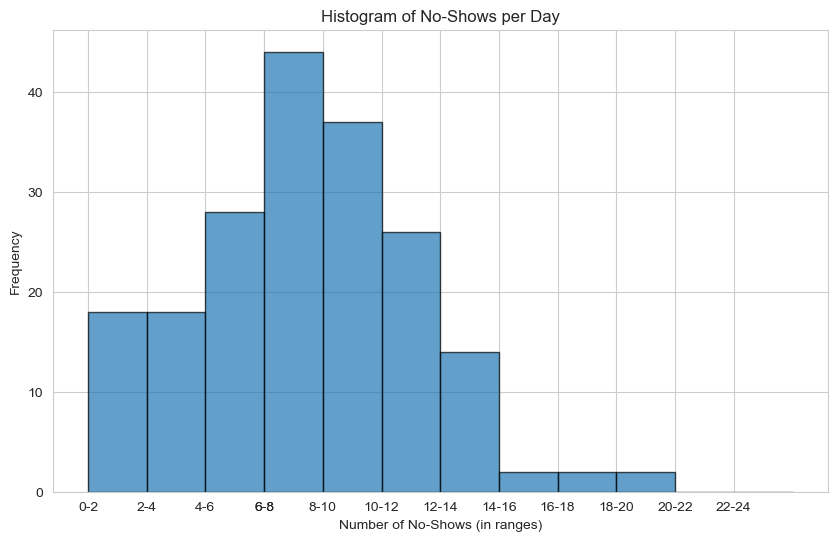

In [459]:
no_show_history = extract_no_show_history(df, sta3n=657, year=2023)

# Tracer l'histogramme de la distribution des No-show
plot_no_show_histogram(no_show_history)

In [460]:
no_show_history

,date,no_show_count
0,2023-01-02,1
1,2023-01-03,13
2,2023-01-04,6
3,2023-01-05,3
4,2023-01-06,5
...,...,...
186,2023-08-24,8
187,2023-08-25,7
188,2023-08-28,6
189,2023-08-29,7


In [461]:
save_dataframe(no_show_history, 'historique_nombre_noshow')

In [462]:
y_pred_ann = y_pred_xgb_st

NameError: name 'y_pred_xgb_st' is not defined

In [463]:
y_pred_xgb_st

NameError: name 'y_pred_xgb_st' is not defined

In [1179]:
# Chargement du modèle
from joblib import load
best_xgb_model = load('best_xgb_model_v7.joblib')
print("Paramètres du modèle de modele_rf_regressor:")
print(best_xgb_model.get_params())
# Predict on the training set and the test set
y_pred_xgb_st = best_xgb_model.predict(X)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
def evaluate_model_performance(y_test, y_pred_test):
    """
    Evaluate the performance of a regression model and print the metrics.

    Args:
        model: Trained regression model.
        X_train (dataFrame): Training features.
        y_train (Series): Training target variable.
        X_test (dataFrame): Testing features.
        y_test (Series): Testing target variable.
    """
    # Calculate metrics for the test set
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    print("Testing Metrics:")
    print(f"R-squared: {r2_test}")
    print(f"Mean Absolute Error (MAE): {mae_test}")
    print(f"Mean Squared Error (MSE): {mse_test}")
    print(f"Root Mean Squared Error (RMSE): {rmse_test}")

# Now call the function with actual and predicted values
evaluate_model_performance(y, y_pred_xgb_st)

Paramètres du modèle de modele_rf_regressor:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 15, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': 2, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'alpha': 10, 'random_stae': 0}
Testing Metrics:
R-squared: -0